
# Cooler Failure Prediction using Sensor Data

This notebook demonstrates how to train a machine learning model to predict **cooler failures** using temperature and pressure sensor data.

---

## 📁 Required Data Files

Make sure to place the following files inside a folder named `data/` (in the same directory as this notebook):

- `TS1.txt` to `TS4.txt` — Temperature sensor data  
- `PS1.txt` to `PS6.txt` — Pressure sensor data  
- `status.txt` — Binary failure status (0 or 1) per sample

```
.
├── cooler_model_clean_final.ipynb
└── data/
    ├── TS1.txt
    ├── TS2.txt
    ├── ...
    ├── PS6.txt
    └── status.txt
```

---

## 🧾 Output Files (Auto-generated)

The notebook will automatically generate:

- `evaluation.csv` → detailed prediction results  
- `prediction_chart.png` → failure probability plot  
- `dashboard.html` → HTML dashboard with model performance  


# ❗ Project Setup Instructions

This notebook requires sensor data files (temperature and pressure) to work correctly.

## ✅ Required Data Files

Place the following files in a folder named `data/` in the same directory as this notebook:

- TS1.txt, TS2.txt, TS3.txt, TS4.txt
- PS1.txt, PS2.txt, PS3.txt, PS4.txt, PS5.txt, PS6.txt
- status.txt

## 📂 Folder Structure

```
your_project_folder/
│
├── cooler_model_clean.ipynb
└── data/
    ├── TS1.txt
    ├── TS2.txt
    ├── ...
    └── status.txt
```

Make sure the `data/` folder is in the same directory as this notebook, otherwise the code will not find the files.


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [39]:
# ✅ Define the base path for input files
# Use relative path to "data/" folder for GitHub compatibility
base_path = "./data/"


--- Loaded Sensor Data (Head) ---
         TS1        TS2        TS3        TS4         PS1         PS2  \
0  35.621983  40.978767  38.471017  31.745250  160.673492  109.466914   
1  36.676967  41.532767  38.978967  34.493867  160.603320  109.354890   
2  37.880800  42.442450  39.631950  35.646150  160.347720  109.158845   
3  38.879050  43.403983  40.403383  36.579467  160.188088  109.064807   
4  39.803917  44.332750  41.310550  37.427900  160.000472  108.931434   

        PS3  PS4       PS5       PS6  
0  1.991475  0.0  9.842170  9.728097  
1  1.976234  0.0  9.635142  9.529488  
2  1.972224  0.0  9.530548  9.427949  
3  1.946575  0.0  9.438827  9.337430  
4  1.922707  0.0  9.358762  9.260636  


In [11]:
# Load sensor data
base_path = "./data/"
temp_files = [f"TS{i}.txt" for i in range(1, 5)]
temp_names = [f"TS{i}" for i in range(1, 5)]
pressure_files = [f"PS{i}.txt" for i in range(1, 7)]
pressure_names = [f"PS{i}" for i in range(1, 7)]

In [ ]:
data = {}

In [14]:
# Path to the profile file containing system conditions
profile_path = "E:/automation/IOT/hydrolic/profile.txt"


# Read the profile file without headers, tab-separated
profile_df = pd.read_csv(profile_path, sep="\t", header=None)

# Assign meaningful column names to the profile data
profile_df.columns = [
    "Cooler_Condition",      # Cooler performance percentage
    "Valve_Condition",       # Valve health percentage
    "Pump_Leakage",          # Pump leakage severity
    "Accumulator_Pressure",  # Accumulator pressure
    "Stable_Flag"            # Stability flag
]

# Create the final target label 'Cooler_Failure'
# If Cooler_Condition is 100%, it's '0' (No Failure), otherwise '1' (Failure)
profile_df["Cooler_Failure"] = profile_df["Cooler_Condition"].apply(
    lambda x: 0 if x == 100 else 1
)

# Print a summary of the loaded profile data
print("--- Loaded Profile Data (Head) ---")
print(profile_df.head())
print("\n--- Cooler Failure Counts ---")
print(profile_df["Cooler_Failure"].value_counts())


--- Loaded Profile Data (Head) ---
   Cooler_Condition  Valve_Condition  Pump_Leakage  Accumulator_Pressure  \
0                 3              100             0                   130   
1                 3              100             0                   130   
2                 3              100             0                   130   
3                 3              100             0                   130   
4                 3              100             0                   130   

   Stable_Flag  Cooler_Failure  
0            1               1  
1            1               1  
2            1               1  
3            1               1  
4            1               1  

--- Cooler Failure Counts ---
Cooler_Failure
1    1464
0     741
Name: count, dtype: int64


In [15]:
# Create a copy of sensor data to avoid modifying the original
df_combined = df_all_sensors.copy()

# Reset indexes to ensure proper concatenation
df_combined = df_combined.reset_index(drop=True)
profile_df = profile_df.reset_index(drop=True)

# Concatenate sensor data and profile data (labels) along columns
df_all_with_labels = pd.concat([df_combined, profile_df], axis=1)

# Feature Engineering: Calculate Moving Average (MA) and Derivative (Rate of Change) for TS4
df_all_with_labels["TS4_MA30"] = df_all_with_labels["TS4"].rolling(window=30).mean()
df_all_with_labels["TS4_diff"] = df_all_with_labels["TS4"].diff()

# Drop rows with NaN values (results from rolling() or diff()) and reset index
model_df = df_all_with_labels.dropna().reset_index(drop=True)

# Display the first few rows of the prepared data for modeling
print("--- Prepared Data for Modeling (Head) ---")
print(model_df.head())

--- Prepared Data for Modeling (Head) ---
         TS1        TS2        TS3        TS4         PS1         PS2  \
0  49.824417  54.384833  51.162533  45.799083  157.950735  107.234886   
1  49.928267  54.486567  51.350183  45.932250  157.955000  107.223577   
2  50.034283  54.601767  51.495283  46.073050  157.900428  107.179437   
3  50.169133  54.722583  51.579517  46.083817  157.969262  107.240815   
4  50.284767  54.867333  51.730117  46.207850  157.879928  107.129530   

        PS3  PS4       PS5       PS6  Cooler_Condition  Valve_Condition  \
0  1.734965  0.0  8.778932  8.711481                 3              100   
1  1.737401  0.0  8.770890  8.704261                 3              100   
2  1.733439  0.0  8.763220  8.698756                 3              100   
3  1.737158  0.0  8.758905  8.694085                 3              100   
4  1.733691  0.0  8.752250  8.687686                 3              100   

   Pump_Leakage  Accumulator_Pressure  Stable_Flag  Cooler_Failure  

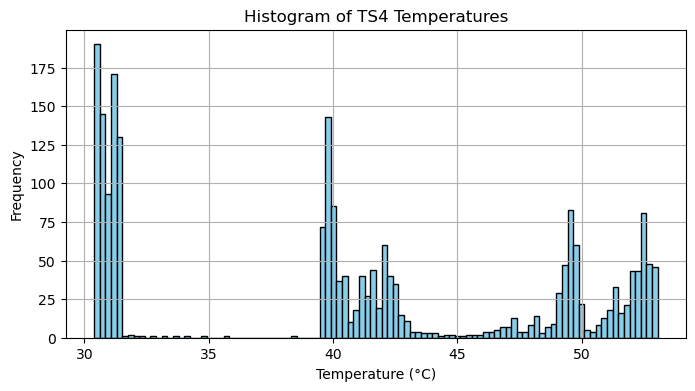

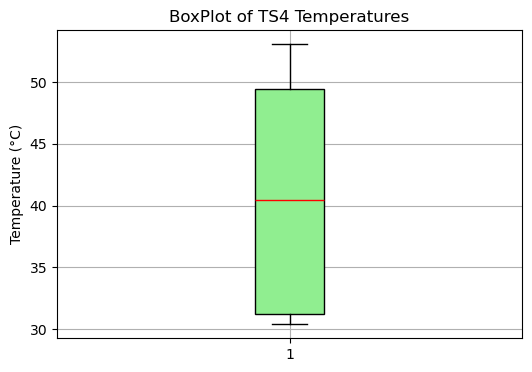

In [16]:
# Convert the TS4 column to a flat NumPy array for distribution analysis
flat_ts4 = model_df["TS4"].to_numpy().flatten()

# --- Histogram of TS4 Temperatures ---
plt.figure(figsize=(8, 4))
plt.hist(flat_ts4, bins=100, color='skyblue', edgecolor='black')
plt.title("Histogram of TS4 Temperatures")
plt.xlabel("Temperature (°C)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# --- BoxPlot of TS4 Temperatures ---
plt.figure(figsize=(6, 4))
plt.boxplot(flat_ts4, vert=True, patch_artist=True,
           boxprops=dict(facecolor='lightgreen'),
           medianprops=dict(color='red'))
plt.title("BoxPlot of TS4 Temperatures")
plt.ylabel("Temperature (°C)")
plt.grid(True)
plt.show()

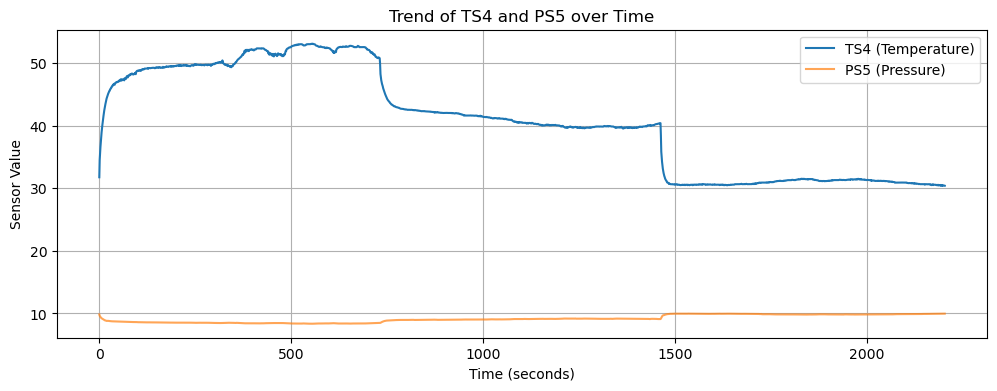

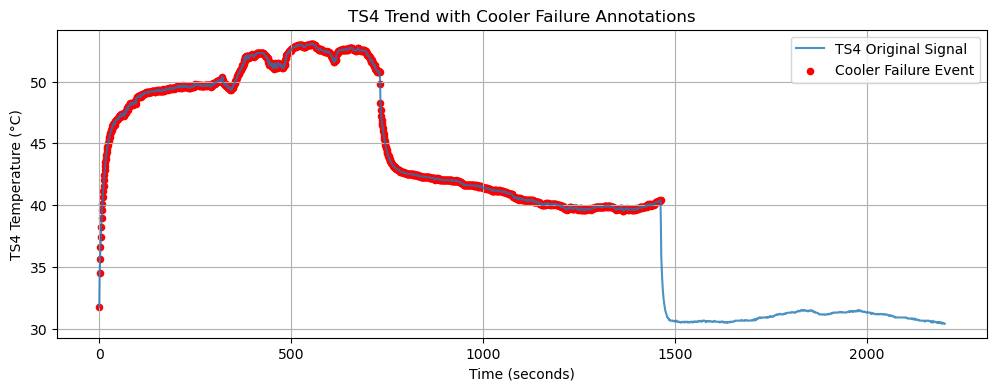

In [17]:
# --- Plotting Trend of TS4 and PS5 over Time ---
plt.figure(figsize=(12, 4))
plt.plot(df_all_with_labels["TS4"], label="TS4 (Temperature)")
plt.plot(df_all_with_labels["PS5"], label="PS5 (Pressure)", alpha=0.7)
plt.legend()
plt.title("Trend of TS4 and PS5 over Time")
plt.xlabel("Time (seconds)")
plt.ylabel("Sensor Value")
plt.grid(True)
plt.show()

# --- Plotting TS4 with Cooler Failure Annotations ---
# Create a boolean condition for 'Cooler_Failure'
condition = df_all_with_labels["Cooler_Condition"] < 100

plt.figure(figsize=(12, 4))
plt.plot(df_all_with_labels["TS4"], alpha=0.8, label="TS4 Original Signal")
plt.scatter(condition[condition].index, df_all_with_labels["TS4"][condition], color='red', label="Cooler Failure Event", s=20)
plt.legend()
plt.title("TS4 Trend with Cooler Failure Annotations")
plt.xlabel("Time (seconds)")
plt.ylabel("TS4 Temperature (°C)")
plt.grid(True)
plt.show()

In [18]:
# Define features (X) and target (y) variables for the model
features = ["TS4", "TS4_MA30", "TS4_diff", "PS5"]
target = "Cooler_Failure"

# Separate features (X) and target (y) from the prepared DataFrame
X = model_df[features]
y = model_df[target]

# Split data into training and testing sets (80% train, 20% test)
# stratify=y ensures balanced class distribution in both sets
# random_state=42 ensures reproducibility
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Print the shapes of the split datasets for verification
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (1740, 4)
y_train shape: (1740,)
X_test shape: (436, 4)
y_test shape: (436,)


In [22]:
# Initialize the RandomForestClassifier model
# n_estimators=100: Build 100 decision trees
# random_state=42: Ensure reproducible results
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model using the training data
model.fit(X_train, y_train)

# Make predictions on the unseen test data
y_pred = model.predict(X_test) # Predicts final class (0 or 1)
y_proba = model.predict_proba(X_test)[:, 1] # Predicts probability of class 1 (failure)

--- Classification Report ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       148
           1       1.00      1.00      1.00       288

    accuracy                           1.00       436
   macro avg       1.00      1.00      1.00       436
weighted avg       1.00      1.00      1.00       436


--- Confusion Matrix ---
[[148   0]
 [  0 288]]


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\vshak\\data\\prediction_chart.png'

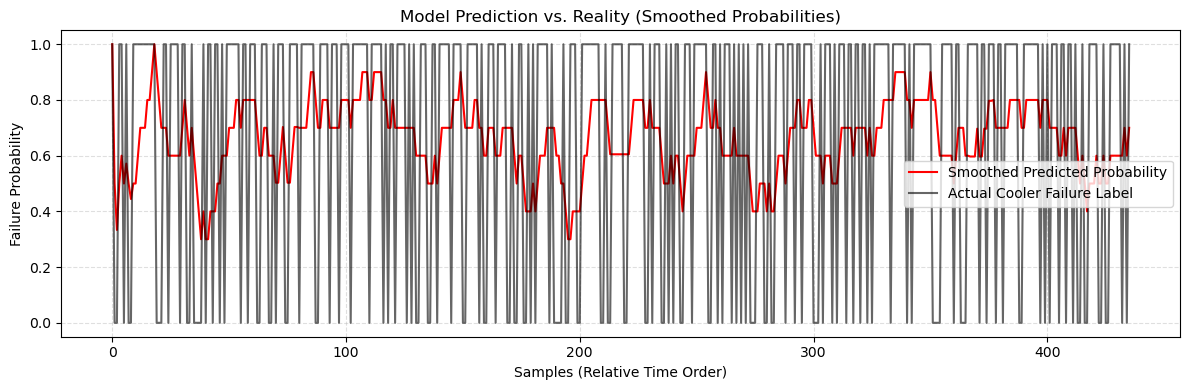

In [36]:
# Print the Classification Report (Precision, Recall, F1-Score for each class)
print("--- Classification Report ---")
print(classification_report(y_test, y_pred))

# Print the Confusion Matrix (counts of TP, TN, FP, FN)
print("\n--- Confusion Matrix ---")
print(confusion_matrix(y_test, y_pred))

# Plotting Smoothed Predicted Probabilities vs. Actual Labels
smooth_proba = pd.Series(y_proba).rolling(window=10, min_periods=1).mean()

plt.figure(figsize=(12, 4))
plt.plot(smooth_proba, label="Smoothed Predicted Probability", color='red')
plt.plot(y_test.reset_index(drop=True).values, label="Actual Cooler Failure Label", alpha=0.6, color='black')
plt.xlabel("Samples (Relative Time Order)")
plt.ylabel("Failure Probability")
plt.title("Model Prediction vs. Reality (Smoothed Probabilities)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.savefig(base_path + "prediction_chart.png", dpi=300, bbox_inches="tight")
plt.show()


--- Feature Importances ---
    Feature  Importance
0       TS4    0.540623
3       PS5    0.279470
1  TS4_MA30    0.179157
2  TS4_diff    0.000750


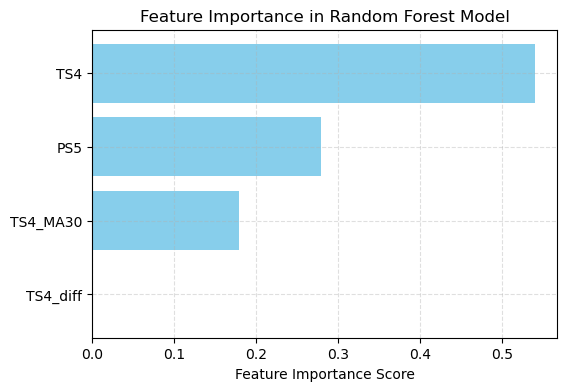

In [24]:
# Re-create the smoothed probability line
smooth_proba = pd.Series(y_proba).rolling(window=10, min_periods=1).mean()

# Plot the prediction vs actual labels
plt.figure(figsize=(12, 4))
plt.plot(smooth_proba, label="Smoothed Predicted Probability", color='red')
plt.plot(y_test.reset_index(drop=True).values, label="Actual Cooler Failure Label", alpha=0.6, color='black')
plt.xlabel("Samples (Relative Time Order)")
plt.ylabel("Failure Probability")
plt.title("Model Prediction vs. Reality (Smoothed Probabilities)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.4)

# Save to file
plt.savefig("E:/automation/IOT/prediction_chart.png", dpi=300, bbox_inches="tight")
print("✅ prediction_chart.png saved successfully.")


In [34]:
# Combine actual labels, predicted labels, and probabilities into a single DataFrame
evaluation_df = pd.DataFrame({
    "Actual": y_test.reset_index(drop=True),
    "Predicted": y_pred,
    "Probability": y_proba
})

# Define a function to classify each prediction case (TP, TN, FP, FN)
def classify_case(row):
    if row["Actual"] == 1 and row["Predicted"] == 1:
        return "True Positive"
    elif row["Actual"] == 0 and row["Predicted"] == 0:
        return "True Negative"
    elif row["Actual"] == 0 and row["Predicted"] == 1:
        return "False Positive"
    elif row["Actual"] == 1 and row["Predicted"] == 0:
        return "False Negative"

# Apply the classification function to create a new column 'Prediction_Type'
evaluation_df["Prediction_Type"] = evaluation_df.apply(classify_case, axis=1)

# Display the first few rows of the detailed evaluation DataFrame
print("--- Detailed Prediction Evaluation (Head) ---")
print(evaluation_df.head())

# Display the counts of each prediction type
print("\n--- Summary of Prediction Types ---")
print(evaluation_df["Prediction_Type"].value_counts())

# Define the path for saving output files
output_path = base_path # Assuming base_path is defined from earlier cells

# Save the evaluation DataFrame to a CSV file (useful for Streamlit app later)
evaluation_df.to_csv(output_path + "evaluation.csv", index=False)
print(f"\nEvaluation data saved to: {output_path}evaluation.csv")

# Save the last prediction chart (smoothed probabilities) as a PNG image for the HTML dashboard
plt.savefig(output_path + "prediction_chart.png", dpi=300, bbox_inches="tight")
print(f"Prediction chart saved to: {output_path}prediction_chart.png")

# --- Create a simple HTML Dashboard ---
# This HTML code uses Tailwind CSS via CDN for basic styling and embeds the saved chart
html_code = f"""
<!DOCTYPE html>
<html lang="en">
<head>
  <meta charset="UTF-8">
  <title>Cooler Failure Prediction Dashboard</title>
  <meta name="viewport" content="width=device=width, initial-scale=1.0">
  <link href="https://cdn.jsdelivr.net/npm/tailwindcss@2.2.19/dist/tailwind.min.css" rel="stylesheet">
</head>
<body class="bg-gray-100 p-6">
  <div class="max-w-5xl mx-auto">
    <h1 class="text-2xl font-bold mb-4 text-center">Cooler Failure Prediction Dashboard</h1>

    <div class="grid grid-cols-2 gap-4">
      <div class="bg-white p-4 rounded-xl shadow">
        <h2 class="text-lg font-semibold mb-2">Model Prediction Statistics</h2>
        <ul class="text-sm space-y-1">
          <li><strong>True Positives:</strong> {evaluation_df["Prediction_Type"].value_counts().get("True Positive", 0)}</li>
          <li><strong>True Negatives:</strong> {evaluation_df["Prediction_Type"].value_counts().get("True Negative", 0)}</li>
          <li><strong>False Positives:</strong> {evaluation_df["Prediction_Type"].value_counts().get("False Positive", 0)}</li>
          <li><strong>False Negatives:</strong> {evaluation_df["Prediction_Type"].value_counts().get("False Negative", 0)}</li>
        </ul>
      </div>

      <div class="bg-white p-4 rounded-xl shadow">
        <h2 class="text-lg font-semibold mb-2">Model Performance</h2>
        <ul class="text-sm">
          <li><strong>Overall Accuracy:</strong> {round(classification_report(y_test, y_pred, output_dict=True)['accuracy'] * 100, 2)}%</li>
          <li><strong>Precision (Failure Class):</strong> {round(classification_report(y_test, y_pred, output_dict=True)['1']['precision'] * 100, 2)}%</li>
          <li><strong>Recall (Failure Class):</strong> {round(classification_report(y_test, y_pred, output_dict=True)['1']['recall'] * 100, 2)}%</li>
        </ul>
      </div>
    </div>

    <div class="bg-white p-4 rounded-xl shadow mt-6">
      <h2 class="text-lg font-semibold mb-4">Prediction Trend Over Time</h2>
      <img src="prediction_chart.png" alt="Model Prediction Chart" class="w-full rounded-md border">
      <p class="text-xs text-gray-500 mt-2 text-center">Red Line: Predicted Probability | Black Line: Actual Status</p>
    </div>
  </div>
</body>
</html>
"""

# Save the HTML content to a file
with open(output_path + "dashboard.html", "w", encoding="utf-8") as file:
    file.write(html_code)
print(f"HTML dashboard saved to: {output_path}dashboard.html")

--- Detailed Prediction Evaluation (Head) ---
   Actual  Predicted  Probability Prediction_Type
0       1          1          1.0   True Positive
1       0          0          0.0   True Negative
2       0          0          0.0   True Negative
3       1          1          1.0   True Positive
4       1          1          1.0   True Positive

--- Summary of Prediction Types ---
Prediction_Type
True Positive    288
True Negative    148
Name: count, dtype: int64


OSError: Cannot save file into a non-existent directory: 'data'